<div style="text-align: center;">
    <img src="https://media.licdn.com/dms/image/v2/D5612AQHAMDWC4URvnw/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1703585611284?e=1745452800&v=beta&t=bAUlHqwbzl0t_Wh93FvrG7FrWE08Uizh7NXtV12FqjY" alt="Numpy Logo" width="500">
    <p style="font-size: 50px; font-weight: bold;">Detecting Phishing Emails</p>
    <p style="font-size: 50px; font-weight: normal;"> Intern BCC 2025</p>
</div>

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score)
from urllib.parse import urlparse
import nltk
nltk.download('punkt')
import os

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# 2. Load dataset (email.csv)
#Lakukan preprocessing:
#    a. Ubah semua teks (subject, body) menjadi lowercase
#    b. Hapus karakter selain huruf dan spasi pada subject dan body
#    c. Ekstrak jumlah URL dari kolom urls
# Gabungkan kolom subject dan body menjadi satu kolom "text"
# Gunakan CountVectorizer atau TF-IDF untuk mengubah teks (subject + body) menjadi fitur numerik
# Gabungkan fitur numerik teks dengan fitur jumlah URL
# Pisahkan dataset menjadi data pelatihan (70%) dan data pengujian (30%)
# Pilih model (Voting Classifier dengan Naive Bayes dan SVM)
# Latih model menggunakan data pelatihan
# Evaluasi model menggunakan data pengujian:
# Hitung akurasi
# Hitung precision, recall, dan F1-score
# Untuk prediksi email baru:
# Preprocess email baru (text, url count)
# Gunakan model untuk memprediksi apakah email phishing atau tidak##

# Data Processing

proses pengumpulan data mentah dan mentransformasi data tersebut menjadi informasi

# Data Cleaning
- Menghapus karakter aneh
- Menghapus tanda baca dan HTML tags

In [3]:
input_paths = []
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)
        input_paths.append(file_path)

../data\CEAS_08.csv
../data\Enron.csv
../data\Ling.csv
../data\Nazario.csv
../data\Nigerian_Fraud.csv
../data\phishing_email.csv
../data\SpamAssasin.csv


In [4]:
# # Remove unwanted files (adjust these paths as needed)
# for unwanted in ["../data/phishing_email.csv",
#                 "../data/Enron.csv",
#                 "../data/Ling.csv",
#                 "../data/Nigerian_Fraud.csv"]:
#     if unwanted in input_paths:
#         input_paths.remove(unwanted)

In [5]:
dataframes = [pd.read_csv(path) for path in input_paths]
df = pd.concat(dataframes, axis=0, ignore_index=True)
df = df.dropna(subset=['body'])
df.reset_index(drop=True, inplace=True)

In [6]:
# Basic EDA
print(df.head())
print(df.info())
print(df.isnull().sum())

                                              sender  \
0                   Young Esposito <Young@iworld.de>   
1                       Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                 Michael Parker <ivqrnai@pobox.com>   
4  Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28:00 -1200   
3  Tue, 05 Aug 2008 17:31:20 -0600   
4  Tue, 05 Aug 2008 19:31:21 -0400   

                                             subject  \
0                          Never agree to be a loser   
1  

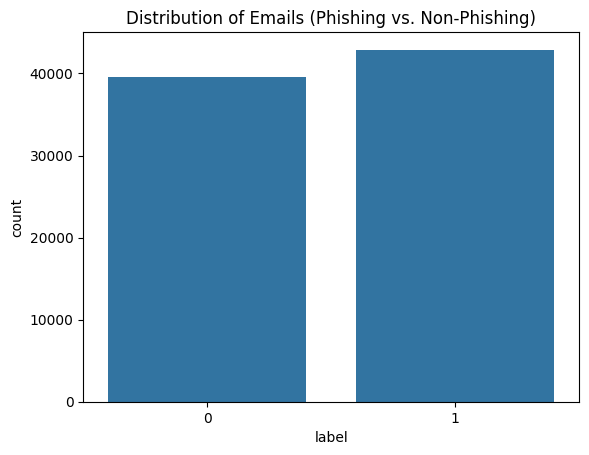

In [7]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Emails (Phishing vs. Non-Phishing)')
plt.show()

In [8]:
df.columns

Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls',
       'text_combined'],
      dtype='object')

In [9]:
df.head()

,sender,receiver,date,subject,body,label,urls,text_combined
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1.0,NaN
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1.0,NaN
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1.0,NaN
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1.0,NaN
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1.0,NaN


In [16]:
df.loc[:,["year"]]

,year
0,2008.0
1,2008.0
2,2008.0
3,2008.0
4,2008.0
...,...
82480,2002.0
82481,2002.0
82482,2003.0
82483,2020.0


In [10]:
df.loc[1:10, ["date"]]

,date
1,"Tue, 05 Aug 2008 18:31:03 -0500"
2,"Tue, 05 Aug 2008 20:28:00 -1200"
3,"Tue, 05 Aug 2008 17:31:20 -0600"
4,"Tue, 05 Aug 2008 19:31:21 -0400"
5,"Wed, 06 Aug 2008 05:31:22 +0600"
6,"Tue, 05 Aug 2008 21:44:01 +0000"
7,"Tue, 05 Aug 2008 20:41:14 -0300"
8,"Tue, 05 Aug 2008 15:31:03 -0800"
9,"Wed, 06 Aug 2008 00:31:38 +0100"
10,"Tue, 05 Aug 2008 21:44:06 +0000"


In [14]:
df.shape

(82485, 9)

In [12]:
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)

df["year"] = df["date"].dt.year

year_range = (df["year"].min(), df["year"].max())
year_range


(1980.0, 2100.0)

In [13]:
df["date"].head(10)

0   2008-08-05 23:31:02+00:00
1   2008-08-05 23:31:03+00:00
2   2008-08-06 08:28:00+00:00
3   2008-08-05 23:31:20+00:00
4   2008-08-05 23:31:21+00:00
5   2008-08-05 23:31:22+00:00
6   2008-08-05 21:44:01+00:00
7   2008-08-05 23:41:14+00:00
8   2008-08-05 23:31:03+00:00
9   2008-08-05 23:31:38+00:00
Name: date, dtype: datetime64[ns, UTC]

In [15]:
df.columns

Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls',
       'text_combined', 'year'],
      dtype='object')

In [17]:
df.isna()

,sender,receiver,date,subject,body,label,urls,text_combined,year
0,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
82480,False,False,False,False,False,False,False,True,False
82481,False,False,False,False,False,False,False,True,False
82482,False,False,False,False,False,False,False,True,False
82483,False,False,False,False,False,False,False,True,False


In [18]:
df.duplicated

<bound method DataFrame.duplicated of                                                   sender  \
0                       Young Esposito <Young@iworld.de>   
1                           Mok <ipline's1983@icable.ph>   
2      Daily Top 10 <Karmandeep-opengevl@universalnet...   
3                     Michael Parker <ivqrnai@pobox.com>   
4      Gretchen Suggs <externalsep1@loanofficertool.com>   
...                                                  ...   
82480  Professional_Career_Development_Institute@Frug...   
82481                          "IQ - TBA" <tba@insiq.us>   
82482                               Mike <raye@yahoo.lv>   
82483                   "Mr. Clean" <cweqx@dialix.oz.au>   
82484  "wilsonkamela400@netscape.net" <wilsonkamela50...   

                                             receiver  \
0                         user4@gvc.ceas-challenge.cc   
1                       user2.2@gvc.ceas-challenge.cc   
2                       user2.9@gvc.ceas-challenge.cc   
3      SpamAs

In [19]:
df["year"]

0        2008.0
1        2008.0
2        2008.0
3        2008.0
4        2008.0
          ...  
82480    2002.0
82481    2002.0
82482    2003.0
82483    2020.0
82484       NaN
Name: year, Length: 82485, dtype: float64